2025-03-22 04:39:23.122059: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742618363.194795   42985 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742618363.214578   42985 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742618363.367451   42985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742618363.367486   42985 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742618363.367488   42985 computation_placer.cc:177] computation placer alr

(40000, 1000)
(40000, 10)


ValueError: x and y must have same first dimension, but have shapes (100,) and (10,)

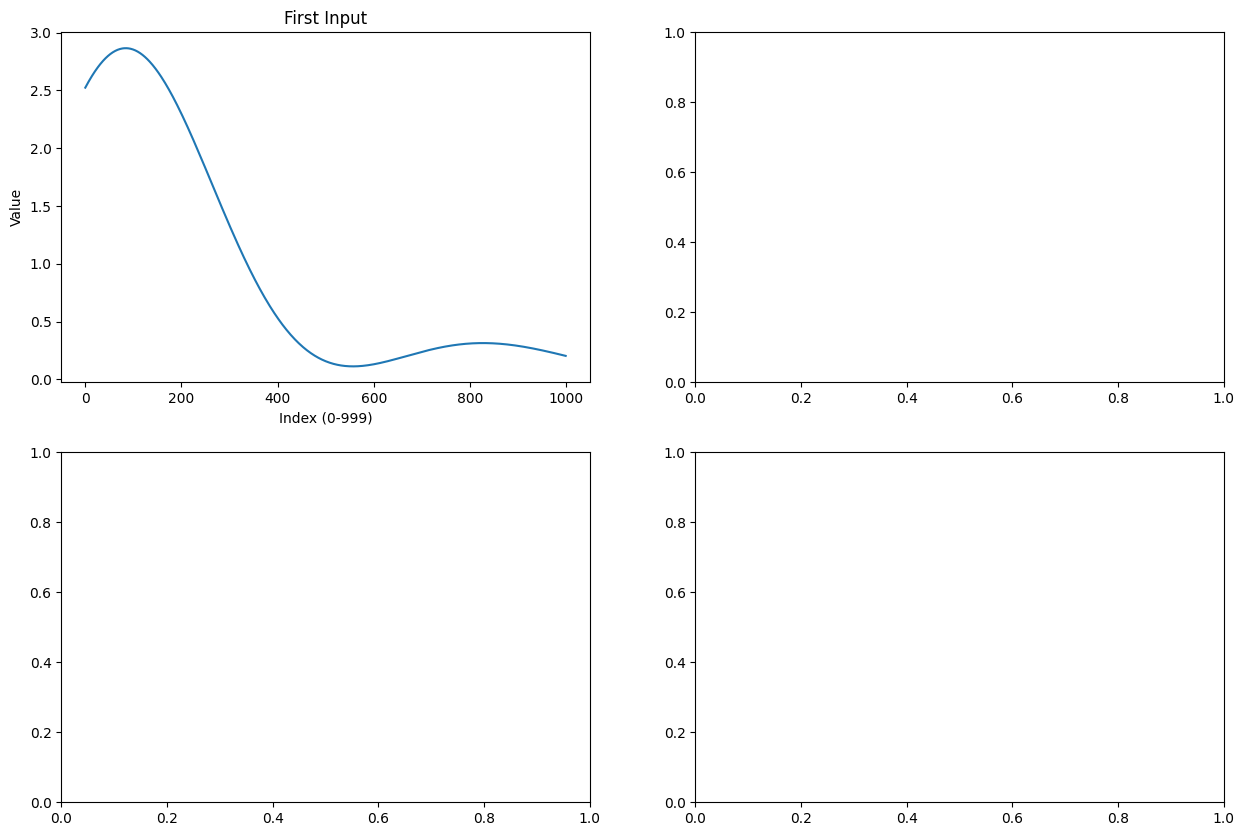

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from syuron import dataset
from workspace import path
import tensorflow as tf

filepath = path.Path("research/syuron/dataset/chirped_scaled2.tfrecord")
ds = dataset.load(filepath, 50000)
batch = next(iter(ds))
inputs, outputs = batch
print(inputs.shape)
print(outputs.shape)
# tf.data.Dataset.from_tensor_slices((inputs, outputs * 10)).save(
#     path.Path("research/syuron/dataset/chirped_scaled2.tfrecord").abs())

# 最初と最後のデータポイントを取得
first_input = inputs[0]
first_output = outputs[0]
last_input = inputs[-1]
last_output = outputs[-1]

# 横軸を作成
input_x = jnp.linspace(0, 999, 1000)
output_x = jnp.linspace(0, 9, 100)

# プロットを作成
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 最初のinputをプロット
axs[0, 0].plot(input_x, first_input)
axs[0, 0].set_title('First Input')
axs[0, 0].set_xlabel('Index (0-999)')
axs[0, 0].set_ylabel('Value')

# 最初のoutputをプロット
axs[0, 1].plot(output_x, first_output, 'o-')
axs[0, 1].set_title('First Output')
axs[0, 1].set_xlabel('Index (0-9)')
axs[0, 1].set_ylabel('Value')

# 最後のinputをプロット
axs[1, 0].plot(input_x, last_input)
axs[1, 0].set_title('Last Input')
axs[1, 0].set_xlabel('Index (0-999)')
axs[1, 0].set_ylabel('Value')

# 最後のoutputをプロット
axs[1, 1].plot(output_x, last_output, 'o-')
axs[1, 1].set_title('Last Output')
axs[1, 1].set_xlabel('Index (0-9)')
axs[1, 1].set_ylabel('Value')

plt.tight_layout()
plt.show()

In [2]:
from syuron import dataset
from syuron import mgoslt
from syuron import mlp
from workspace import path


filepath = path.Path("research/syuron/dataset/chirped_scaled2.tfrecord")
ds = dataset.load(filepath)
final_state, final_loss = mgoslt.train_and_eval(
    ds, 10, mlp.OptimizableParams(learning_rate=1e-3, hidden_sizes=[128, 64]))
print("Training completed. Final model loss:")
print(final_loss)

# final_state, final_loss = mgoslt.bayesian_optim_and_eval(ds)

Initial loss: 820.03314


Epoch 1/10: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s]


Epoch 1: Average Loss = 206.30833435058594


Epoch 2/10: 100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Epoch 2: Average Loss = 5.89882230758667


Epoch 3/10: 100%|██████████| 40/40 [00:03<00:00, 12.89it/s]


Epoch 3: Average Loss = 4.503291130065918


Epoch 4/10: 100%|██████████| 40/40 [00:03<00:00, 13.12it/s]


Epoch 4: Average Loss = 4.25120735168457


Epoch 5/10: 100%|██████████| 40/40 [00:03<00:00, 12.65it/s]


Epoch 5: Average Loss = 3.979088306427002


Epoch 6/10: 100%|██████████| 40/40 [00:03<00:00, 13.05it/s]


Epoch 6: Average Loss = 3.985497236251831


Epoch 7/10: 100%|██████████| 40/40 [00:03<00:00, 12.99it/s]


Epoch 7: Average Loss = 3.6928718090057373


Epoch 8/10: 100%|██████████| 40/40 [00:03<00:00, 10.98it/s]


Epoch 8: Average Loss = 3.220029592514038


Epoch 9/10: 100%|██████████| 40/40 [00:06<00:00,  6.42it/s]


Epoch 9: Average Loss = 2.725385904312134


Epoch 10/10: 100%|██████████| 40/40 [00:12<00:00,  3.18it/s]

Epoch 10: Average Loss = 2.2277040481567383
Training completed. Final model loss:
2.227704


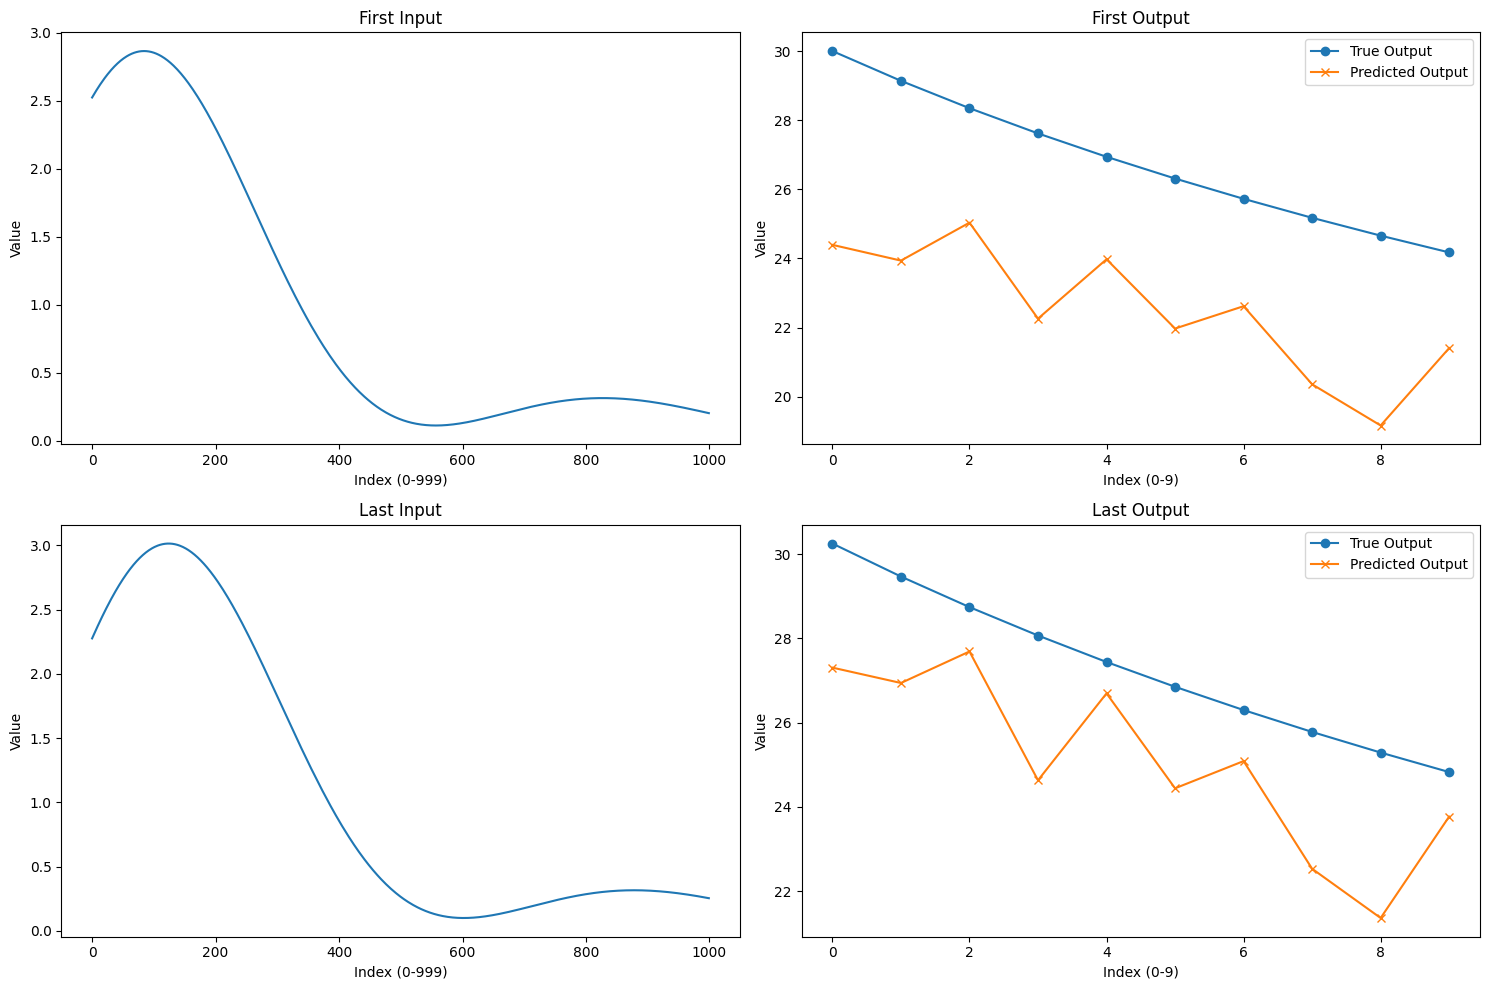

: 

In [ ]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

# 学習済みモデルを使用して予測を取得
batch = next(iter(ds))
inputs, outputs = batch

# state.apply_fnを使って予測を行う
# 注意: state.apply_fnの引数は (params, inputs) または (params, inputs, rng) の形式です。
# rngが必要な場合は、適切な乱数生成器を渡してください。
predictions = final_state.apply_fn(final_state.params, inputs)

# 最初と最後のデータポイントを取得
first_input = inputs[0]
first_output = outputs[0]
first_prediction = predictions[0]

last_input = inputs[-1]
last_output = outputs[-1]
last_prediction = predictions[-1]

# 横軸を作成
input_x = jnp.linspace(0, 999, 1000)
output_x = jnp.linspace(0, 9, 10)

# プロットを作成
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# 最初のinputをプロット
axs[0, 0].plot(input_x, first_input)
axs[0, 0].set_title('First Input')
axs[0, 0].set_xlabel('Index (0-999)')
axs[0, 0].set_ylabel('Value')

# 最初のoutputと予測をプロット
axs[0, 1].plot(output_x, first_output, 'o-', label='True Output')
axs[0, 1].plot(output_x, first_prediction, 'x-', label='Predicted Output')
axs[0, 1].set_title('First Output')
axs[0, 1].set_xlabel('Index (0-9)')
axs[0, 1].set_ylabel('Value')
axs[0, 1].legend()

# 最後のinputをプロット
axs[1, 0].plot(input_x, last_input)
axs[1, 0].set_title('Last Input')
axs[1, 0].set_xlabel('Index (0-999)')
axs[1, 0].set_ylabel('Value')

# 最後のoutputと予測をプロット
axs[1, 1].plot(output_x, last_output, 'o-', label='True Output')
axs[1, 1].plot(output_x, last_prediction, 'x-', label='Predicted Output')
axs[1, 1].set_title('Last Output')
axs[1, 1].set_xlabel('Index (0-9)')
axs[1, 1].set_ylabel('Value')
axs[1, 1].legend()

plt.tight_layout()
plt.show()